##Training the CNN model

In [5]:
#importing the necessay libraries
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

################################################################################################################
#upload the JSON file containing the MFCC features
DATA_PATH="/content/datasetTorF.json"


################################################################################################################
#loading the features from the JSON file
def load_data(data_path):

  with open(data_path, "r") as fp:
    data = json.load(fp)
  
  X = np.array(data["mfcc"])
  y = np.array(data["labels"])

  return X,y


###############################################################################################################
#Splitting the dataset into train, test and validation sets.
def prepare_datasets(test_size, validation_size):

  #calling the load_data function
  X,y = load_data(DATA_PATH)

  #create train/test split
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size)

  #create train/validation split
  X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train, test_size=validation_size)

  # 3d array -> (130,13,1)
  X_train = X_train[..., np.newaxis]  #4d array (num_samples, 130,13,1)
  X_validation = X_validation[..., np.newaxis]
  X_test = X_test[..., np.newaxis]

  return X_train, X_validation, X_test, y_train, y_validation, y_test


##############################################################################################################
#Training the dataset
def build_model(input_shape):

  #create a model
  model = keras.Sequential()

  #1st convolution layer
  model.add(keras.layers.Conv2D(256, (3,3), activation="relu", input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((2,2), strides=(2,2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  #2nd convolution layer
  model.add(keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=input_shape,padding='same' ))
  model.add(keras.layers.MaxPool2D((2,2), strides=(2,2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  #3rd convolution layer
  model.add(keras.layers.Conv2D(32, (2,2), activation="relu", input_shape=input_shape,padding='same'))
  model.add(keras.layers.MaxPool2D((2,2), strides=(2,2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  #flatten the output and feed it into dense layer
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(16, activation='relu'))
  model.add(keras.layers.Dropout(0.3))

  #output layer
  model.add(keras.layers.Dense(2, activation='softmax'))

  return model


############################################################################################################
#main program
if __name__ =="__main__":
  #create train, validation and test sets
  X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25,0.2)

  #build the CNN net
  input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3] )  #4d array ->( num_of _samples, 130,13,1)
  model = build_model(input_shape)

  #compile the net
  optimizer = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=optimizer,
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

  #train  the CNN
  r = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=5, epochs=10)

  #evaluate the CNN on the test set
  test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
  
  #printing the test_accuracy
  print("The accuracy of the test set is {}.".format(test_accuracy))





Epoch 1/10
120/120 [==============================] - 1s 5ms/step - loss: 0.6658 - accuracy: 0.6221 - val_loss: 0.5411 - val_accuracy: 0.7533
Epoch 2/10
120/120 [==============================] - 0s 3ms/step - loss: 0.4101 - accuracy: 0.8094 - val_loss: 0.3994 - val_accuracy: 0.8400
Epoch 3/10
120/120 [==============================] - 0s 3ms/step - loss: 0.4339 - accuracy: 0.7818 - val_loss: 0.3136 - val_accuracy: 0.8667
Epoch 4/10
120/120 [==============================] - 0s 3ms/step - loss: 0.3571 - accuracy: 0.8512 - val_loss: 0.3173 - val_accuracy: 0.8333
Epoch 5/10
120/120 [==============================] - 0s 3ms/step - loss: 0.3373 - accuracy: 0.8419 - val_loss: 0.2994 - val_accuracy: 0.8867
Epoch 6/10
120/120 [==============================] - 0s 3ms/step - loss: 0.3464 - accuracy: 0.8165 - val_loss: 0.2941 - val_accuracy: 0.8200
Epoch 7/10
120/120 [==============================] - 0s 3ms/step - loss: 0.3056 - accuracy: 0.8581 - val_loss: 0.2869 - val_accuracy: 0.8600
Epoch 

##Plotting the accuracy and loss for training and validation set

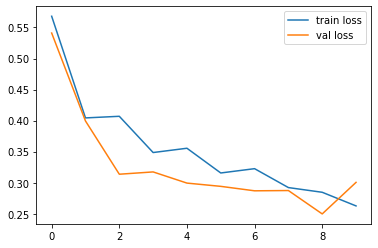

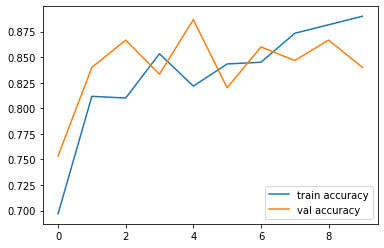

<Figure size 432x288 with 0 Axes>

In [7]:
######################################################################################################
#importing matplot library
import matplotlib.pyplot as plt

# loss plot
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')


# accuracy plot
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

##Making prediction on the sample

In [8]:
########################################################################################################
def predict(model, X,y):

  X = X[np.newaxis, ...]
  prediction = model.predict(X)# X-> (1,130,13,1)

  #extract index with max value
  predicted_index = np.argmax(prediction, axis=1)

  print("Expected index: {}, predicted index: {}".format(y, predicted_index))


X = X_test[11]
y = y_test[11]

predict(model,X,y)

Expected index: 0, predicted index: [0]


##Saving the model

In [9]:
########################################################################################################
import os.path
if os.path.isfile('/content/TrueorFalse_model.h5') is False:
  model.save('/content/TrueorFalse_model.h5')